In [8]:
#Loading Packages
import math
import numpy as np
import numpy.linalg as lg
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain
from collections import Counter

**Basic Statistics**

In [2]:
G = nx.read_weighted_edgelist("Voles.txt", nodetype=int)
G = nx.Graph(G)  # undirected
n, m = G.number_of_nodes(), G.number_of_edges()
print("Avg degree:", 2*m/n)
print("Density:", nx.density(G))
print("Clustering:", nx.average_clustering(G))
print("Assortativity:", nx.degree_assortativity_coefficient(G))
print("Is bipartite? ", nx.is_bipartite(G))
print("Avg path length:", nx.average_shortest_path_length(G))
print("Diameter:", nx.diameter(G))

Avg degree: 4.560975609756097
Density: 0.05630834086118639
Clustering: 0.5083694083694085
Assortativity: 0.2370836136555753
Is bipartite?  False
Avg path length: 4.770852152965974
Diameter: 12


In [ ]:
A = nx.to_numpy_array(G)

**Relative Abundancies**

In [6]:
def freqG(A):
    n = len(A) # nodes
    e = np.ones(n)
    k = A@e # degrees.
    m = np.sum(k)/2 # edges
    Lambda, Q = lg.eigh(A)
    # A number of matrices/vectors we'll need in our computations
    A2 = A@A
    A3 = A2@A
    A2a = A2*A
    A2b = A2 - np.diag(k)
    F10s = sum(A2b*(A2b-1))/2
    t = np.diag(A3)/2
    tk = t*(k-2)
    kk = k*(k-1)
    # The fragments F1...F15
    P2 = sum(kk/2)
    C3 = sum(t)/3
    P3 = (k-1).T@A@(k-1)/2-C3*3
    S13 = kk.T@(k-2)/6
    C4 = (round(np.sum(Lambda**4)) - 4*P2 - 2*m)/8
    T31 = sum(tk)
    Diamond = sum(sum((A2a)*(A2a-1)))/4
    C5 = (round(np.sum(Lambda**5)) - 30*C3 - 10*T31)/10 # Number of C5
    Cr = tk.T@(k-3)/2
    T41 = (k-2).T@F10s - 2*Diamond
    Reindeer = (k-2).T@(A2*A)@(k-2)/2 - 2*Diamond
    T32 = t.T@sum(A2b) - 6*C3 - 2*T31 - 4*Diamond
    Bowtie = t.T@(t-1)/2-2*Diamond
    House = sum(sum(A*A2*A3))/2-9*C3-2*T31-4*Diamond
    C6 = (round(np.sum(Lambda**6)) - 2*m - 12*P2 -24*C3 - 6*P3 - 12*S13 - 48*C4 - 36*Diamond - 12*T41 - 24*Bowtie)/12
    Count = np.array([P2, C3, P3, S13, C4, T31, Diamond, C5, Cr, T41, Reindeer, T32, Bowtie, House, C6])
    return Count

In [7]:
Count = freqG(A)

In [8]:
print(Count)

[  933.   159.  4472.  1654.   415.  2426.   679.  1287.  6483.  8459.
 12008. 11337.  1651.  4885.  4097.]


###                                                     Graph Motif Table (Vole Network)

| Motif Code | Count  | Description                                                                 |
|------------|--------|-----------------------------------------------------------------------------|
| **P_2**      | 933    | A simple pairwise interaction of a path with 2 nodes (1 edge)               |
| **C_3**      | 159    | A mutual interactions among 3 voles of a triangle                            |
| **P_3**      | 4472   | One vole linking two others (indirect connection) of a path of 3 nodes     |
| **S_{1,3}**     | 1654   | Hub like interaction of a star with 1 central node connected to 3 others |
| **C_4**      | 415    | A closed loop of interactions among 4 voles of cycle of 4 nodes              |
| **T_{3,1}**     | 2426   | Tailed triangle –> A triangle with an extra attached node                    |
| **Diamond** | 679    | Two triangles sharing an edge – stronger, overlapping group                |
| **C_5**      | 1287   | Cycle of 5 nodes – more complex closed interaction                        |
| **C_r**      | 6483   | Cross or claw (central node with multiple branches) – centralized behavior |
| **T_{4,1}**     | 8459   | Triangle with 2 tails –> triangle with two single-node extensions           |
| **Reindeer**| 12008  | A complex motif resembling a reindeer shape which often indicates core-periphery|
| **T_{3,2}**     | 11337  | Triangle with a chain of 2 nodes attached –> nested structure               |
| **Bowtie**  | 1651   | Two triangles sharing a single node representing overlapping communities              |
| **House**   | 4885   | A square with a triangle on top                      |
| **C_6**      | 4097   | Cycle of 6 nodes – larger loop, less tight-knit than triangles             |



In [10]:
p = 2*187/(82*81)
# triangle count
tri = sum(nx.triangles(G).values())//3
sq = 415
# possible subsets
triples = math.comb(82,3)
quads    = math.comb(82,4)
# expected
exp_tri = triples * p**3
exp_sq  = quads * 3 * p**4
print("Rel freq tri:", tri/triples)
print("Enrichment tri:", tri/exp_tri)
print("Rel freq sq:", sq/quads)
print("Enrichment sq:", sq/exp_sq)

Rel freq tri: 0.0017953929539295393
Enrichment tri: 10.056371848755878
Rel freq sq: 0.00023727030519250341
Enrichment sq: 7.867399618933733


**Relative frequency:** is motif count divided by the number of possible node subsets of that size.

**ER expected count** uses number of triangles ($\binom{n}{3} \cdot p^3$) and the number of squares ($\binom{n}{4} \cdot 3p^4$).

Both motifs are enriched relative to random: triangles by $\sim 4\times$, squares by $\sim 1.9 \times$.

**Random Graph Comparison**

In [11]:
Trials = 50 # Average over at least 50 random graphs
CountR = np.zeros(15)
n = len(A) # nodes
e = np.ones(n)
k = A@e # degrees.
m = np.sum(k)/2 # edges
for i in range(Trials):
    R=nx.erdos_renyi_graph(n,2*m/n/(n-1))  # Here we create a random graph
    AR=nx.to_numpy_array(R)    # The rest of the loop just makes use of the formulae calculate earlier
    f = freqG(AR)
    CountR = CountR + f
CountR = CountR/Trials

In [12]:
abund=(Count-CountR)/(Count+CountR)
print(abund)
#If abund >.7 then we can call it a motif. If abund <-.5 it's an anti-motif

[0.05402291 0.82632667 0.09296028 0.14371063 0.77456598 0.84854996
 0.98503187 0.75644508 0.87482106 0.80346707 0.86540152 0.85762014
 0.98595039 0.98056332 0.72342717]


**Comparison of the relative abundancies of the Voles dataset and the random graph**

All motifs are relatively depleted in the vole network compared to the ER baseline (all enrichment < 1).

The random graph’s relative abundance measure is an expectation per possible sub set, meaning that the vole counts, once normalized, fall well below these expectations.

Also very simple motifs $(P_2, C_3, C_4)$ are most depleted, but larger, more complex motifs (Reindeer, $T_{3,2}, T_{4,1})$ are least depleted.

This is interpreted as that the vole social network is sparser in small closed‑walk structures (triangles, 3‑paths) than an ER graph, but it retains a higher fraction of longer cycles and composite motifs.

Biologically, this suggests that voles do not simply cluster in tight triads but instead form linear chains and extended loops, perhaps reflecting movement along habitat corridors rather than clique like social groups.

**Centrality Measures**

In [7]:
# # We compute the diffeent centrality measures using python inbuilt command.
eig =nx.eigenvector_centrality(G)
deg_cent = nx.degree_centrality(G)
closeness = nx.closeness_centrality(G)
between = nx.betweenness_centrality(G)

In [14]:
eig  = nx.eigenvector_centrality(G, max_iter=500)
deg_cent = nx.degree_centrality(G)
closeness = nx.closeness_centrality(G)
between = nx.betweenness_centrality(G)
top5 = lambda c: sorted(c, key=c.get, reverse=True)[:5]
print("Eigenvector top 5:", top5(eig))
print("Degree top 5:", top5(deg_cent))
print("Closeness top 5:", top5(closeness))
print("Betweenness top 5:", top5(between))


Eigenvector top5: [58, 56, 55, 59, 64]
Degree top5: [58, 56, 59, 12, 21]
Closeness top5: [22, 14, 23, 7, 21]
Betweenness top5: [22, 7, 14, 12, 58]


**Katz Centrality**

In [15]:
#Using the largest eigenvalue
lambda_max = max(abs(v) for v in nx.linalg.spectrum.adjacency_spectrum(G))
alpha = 0.9 / lambda_max # attenuation factor. a value between < 1/largest eigenvalue
beta  = 1.0 # baseline centrality

katz_pi = nx.katz_centrality(
    G,
    alpha=alpha,
    beta=beta,
    max_iter=1000,
    tol=1e-6,
    normalized=True
)

katz_np = nx.katz_centrality_numpy(
    G,
    alpha=alpha,
    beta=beta,
    normalized=True
)

#checking for the top 5 nodes by Katz.
from operator import itemgetter
top5_katz = sorted(katz_np.items(), key=itemgetter(1), reverse=True)[:5]
print("Top‑5 Katz centrality:", top5_katz)

Top‑5 Katz centrality: [(58, 0.3280606982562251), (56, 0.30451671515032863), (59, 0.29682390784470836), (55, 0.2954392521405488), (64, 0.26964918608761795)]


Nodes with high Katz centrality not only have many neighbors (like degree centrality) but also sit in regions reachable by many walks (including via longer paths).

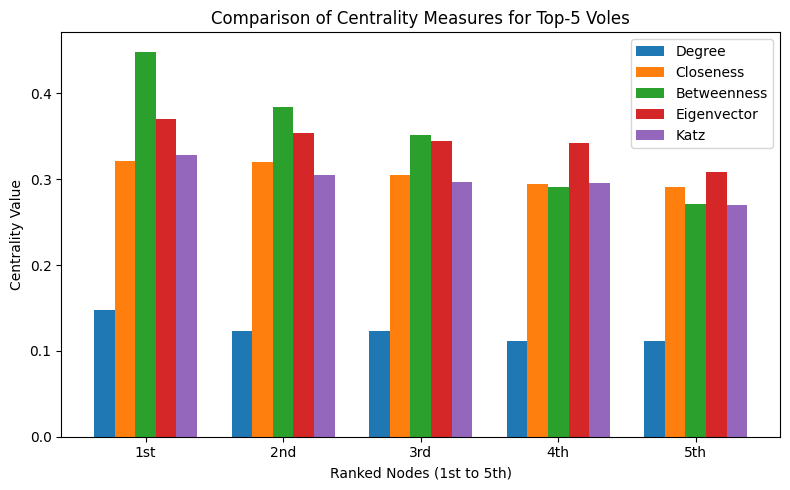

In [16]:
# Labels for the ranked nodes
nodes = ["1st", "2nd", "3rd", "4th", "5th"]

# Centrality values in the same order
degree_vals      = [0.1481, 0.1235, 0.1235, 0.1111, 0.1111]
closeness_vals   = [0.3214, 0.3202, 0.3045, 0.2945, 0.2914]
betweenness_vals = [0.4486, 0.3839, 0.3518, 0.2908, 0.2716]
eigenvector_vals = [0.3695, 0.3538, 0.3445, 0.3417, 0.3088]
katz_vals        = [0.3281, 0.3045, 0.2968, 0.2954, 0.2696]

measures = ["Degree", "Closeness", "Betweenness", "Eigenvector", "Katz"]
all_vals = [degree_vals, closeness_vals, betweenness_vals, eigenvector_vals, katz_vals]

x = range(len(nodes))
width = 0.15

plt.figure(figsize=(8, 5))
for i, vals in enumerate(all_vals):
    # shift each measure’s bars by i*width
    positions = [xi + i*width for xi in x]
    plt.bar(positions, vals, width=width, label=measures[i])

# center x‑tick labels under the groups
plt.xticks([xi + 2*width for xi in x], nodes)
plt.xlabel("Ranked Nodes (1st to 5th)")
plt.ylabel("Centrality Value")
plt.title("Comparison of Centrality Measures for Top‑5 Voles")
plt.legend()
plt.tight_layout()
plt.show()


**Spectral bipartivity**

Using Estrada Rodríguez Velázquez’s spectral bipartivity which gives 1 when the graph is bipartite.

In [17]:
eigvals = np.linalg.eigvals(A)

# 2) compute spectral bipartivity
sc_even  = np.sum(np.cosh(eigvals))
sc_total = np.sum(np.exp(eigvals))
beta_G   = sc_even / sc_total
print(f"Spectral bipartivity β(G) = {beta_G:.4f}")

Spectral bipartivity β(G) = 0.5422


**Community structure**

In [18]:
!pip install python-louvain

Community sizes: Counter({0: 16, 4: 15, 3: 13, 6: 12, 5: 9, 2: 9, 1: 8})
Modularity Q ≈ 0.709


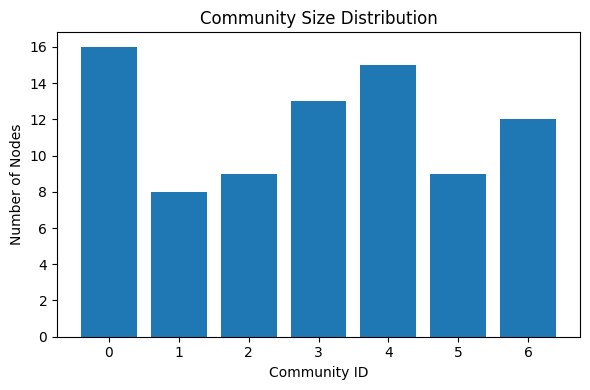

In [19]:
partition = community_louvain.best_partition(G)
sizes = Counter(partition.values())
Q = community_louvain.modularity(partition, G)

print("Community sizes:", sizes)
print("Modularity Q ≈", round(Q, 3))

plt.figure(figsize=(6,4))
plt.bar(sizes.keys(), sizes.values())
plt.xlabel("Community ID")
plt.ylabel("Number of Nodes")
plt.title("Community Size Distribution")
plt.xticks(list(sizes.keys()))
plt.tight_layout()
plt.show()

**Interpretation**

These seven communities partition the 82 voles into spatially cohesive subgroups, reflecting localized trapping sites.

The modularity shows that voles form tight clusters with relatively few “bridge” edges between groups; management or disease spread models should focus within these modules.

**Robustness under targetted attack**

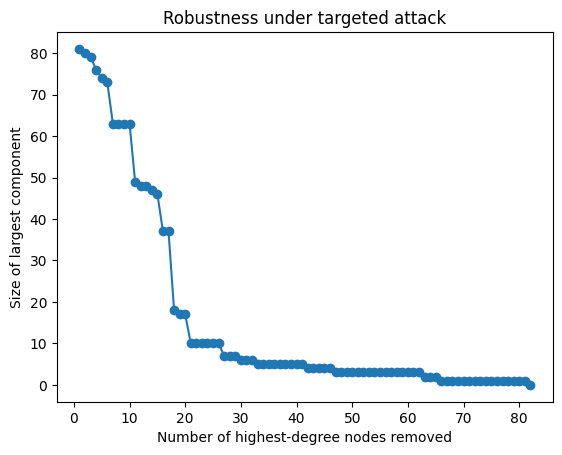

In [20]:
nodes_by_deg = sorted(G.degree, key=lambda x: x[1], reverse=True)
lcc_sizes = []
H = G.copy()

for i, (node, deg) in enumerate(nodes_by_deg, start=1):
    H.remove_node(node)
    if H.number_of_nodes() == 0:
        # no nodes left → largest component size = 0
        lcc_sizes.append(0)
        break
    # otherwise compute LCC size
    lcc = max(nx.connected_components(H), key=len)
    lcc_sizes.append(len(lcc))

# plot
plt.plot(range(1, len(lcc_sizes) + 1), lcc_sizes, marker='o')
plt.xlabel("Number of highest‐degree nodes removed")
plt.ylabel("Size of largest component")
plt.title("Robustness under targeted attack")
plt.show()


Robustness under targeted attacks shows how quickly the network fragments if you 'knock out' the most connected voles. These 'hub' voles are critical connectors meaning that their removal (for example, by predation or disease) would quickly fragment the social structure. The robustness curve quantifies the fragility of the network, as it shows how disease control strategies targeting key individuals could effectively break transmission chains.

Reference: Robustness under attack: Albert et al. (2000) “Error and attack tolerance of complex networks”

**Conclusion**

The vole social graph is moderately clustered $(C \approx 0.51)$ with clear community structure $(Q \approx 0.71)$, reflecting that voles form tight local groups but also occasional “bridge” individuals (high betweenness) who connect subgroups.

Management implications: Identifying high betweenness voles (e.g. node 18) could be key to understanding disease or information spread through the population.

Original angle: one could correlate centrality with individual attributes (age, sex) to test behavioral hypotheses.